In [28]:
# Notebook for testing new functions to add to PandemiXFunctions.py

In [122]:
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define paths
rootdir_data = os.getcwd() +"\\..\\DanskeData\\" 

path_data = rootdir_data + "ssi_data\\"
path_dash = rootdir_data + "ssi_dashboard\\"
path_vacc = rootdir_data + "ssi_vacc\\"

path_figs = os.getcwd() +"\\..\\Figures\\" 

def rnMean(data,meanWidth):
    return np.convolve(data, np.ones(meanWidth)/meanWidth, mode='valid')
def rnTime(t,meanWidth):
    return t[math.floor(meanWidth/2):-math.ceil(meanWidth/2)+1]
def plotMean(xVals,yVals,ax,meanWidth=7, **kwargs):

    ax.plot(xVals,yVals,'.:',linewidth=0.5,markersize=2, **kwargs)
    ax.plot(rnTime(xVals,meanWidth),rnMean(yVals,meanWidth),**kwargs)

    return 

def getCases(type='raw',includeLatest=False,includeReinfections=True,returnReinfections = False,firstDate=np.datetime64('2020-01-27'),lastDate=np.datetime64('today')):
    # # Arguments:
    # type: 
    #     'raw','7daymean','14daymean','21daymean','28daymean','WeeklySum'
    # includeLatest: 
    #     Data is based on testing data, so latest data-point is usually not counted yet. Default: False
    # includeReinfections:
    #     Whether to return the sum of new cases and reinfections or only new cases. Default: True 
    # returnReinfections:
    #     Flag for returning reinfections seperately in case the sum of new cases and reinfection is not returned (see above). Default: False 
    #     Note: If true, 3 arrays are returned: newCases,dates,reinfections. If false, only 2 arrays.
    # firstDate:
    #     Data before day is cutoff (before running means is calculated)
    # lastDate:
    #     Data after day is cutoff (before running means is calculated)


    # # Using data from SSI_data does not include reinfektion. However, the loading is kept here for posterity...
    # latestsubdir = list(os.walk(path_data))[0][1][-1]
    # latestdir = path_data + latestsubdir
    # dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
    # dfCase = dfCase.iloc[:-2]
    # dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))
    # dfCase['Date'] =  pd.to_datetime(dfCase.Date,format='%Y-%m-%d')
    # # Remove dates outside range
    # dfCase = dfCase[(dfCase.Date >= firstDate) & (dfCase.Date <= lastDate)]
    # # Latest datapoint is not yet fully counted and should often be ignored.
    # if (includeLatest):
    #     curCases = dfCase['NewPositive'].values
    #     curDates = dfCase['Date'].values
    # else:
    #     curCases = dfCase['NewPositive'].values[:-1]
    #     curDates = dfCase['Date'].values[:-1]

    # Correct loading, using the regional dashboard files which include both new cases and reinfections
    latestsubdir = list(os.walk(path_dash))[0][1][-1]
    latestdir = path_dash + latestsubdir

    df = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
    df['Prøvedato'] = pd.to_datetime(df['Prøvedato'])
    # groupdf = df.groupby(['Prøvedato').sum()
    df_reinf = df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
    df_inf = df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()

    curDates = df_inf.index.values 

    newCases = df_inf.infected.values
    reInfCases = df_reinf.infected.values



    # if includeReinfections:
    #     curCases = newCases + reInfCases
    # else:
    #     curCases = newCases

    # Latest datapoint is not yet fully counted and should often be ignored.
    if (includeLatest == False):
        # curCases = curCases[:-1]
        curDates = curDates[:-1]
        newCases = newCases[:-1]
        reInfCases = reInfCases[:-1]
    
    if (type == '7daymean'):
        curDates = rnTime(curDates,7)
        newCases = rnMean(newCases,7)
        reInfCases = rnMean(reInfCases,7)
    elif (type == '14daymean'):
        curDates = rnTime(curDates,14)
        newCases = rnMean(newCases,14)
        reInfCases = rnMean(reInfCases,14)
    elif (type == '21daymean'):
        curDates = rnTime(curDates,21)
        newCases = rnMean(newCases,21)
        reInfCases = rnMean(reInfCases,21)
    elif (type == '28daymean'):
        curDates = rnTime(curDates,28)
        newCases = rnMean(newCases,28)
        reInfCases = rnMean(reInfCases,28)
    elif (type == 'WeeklySum'):
        # Summing from monday to sunday.
        # If firstDate is not a monday, some days are missing in beginning
        # If lastDate is not a sunday, some days are missing in the end
        
        # Since the dates returned are the mondays of the given week, 
        # the correct way to plot is step with where='post', i.e. ax.step(dates,cases,where='post')

        curWeekDay = pd.to_datetime(firstDate).dayofweek
        firstMonday = firstDate - np.timedelta64(curWeekDay,'D')

        curOffset = 0
        curMonday = firstMonday

        weekNewCases = []
        weekReInfCases = []
        weekCurDates = []
        while (curMonday < lastDate):
            weekNewCases.append(newCases[curOffset:curOffset+7].sum())
            weekReInfCases.append(reInfCases[curOffset:curOffset+7].sum())
            weekCurDates.append(curMonday)

            curMonday = curMonday + np.timedelta64(7,'D')
            curOffset = curOffset + 7
        
        # toReturn = np.array(weekNewCases),np.array(weekCurDates)
        curDates = weekCurDates
        newCases = weekNewCases
        reInfCases = weekReInfCases
    
    if includeReinfections:
        return (newCases+reInfCases),curDates
    else:
        if returnReinfections:
            return newCases,curDates,reInfCases
        else:
            return newCases,curDates

(18962.0, 19020.0)

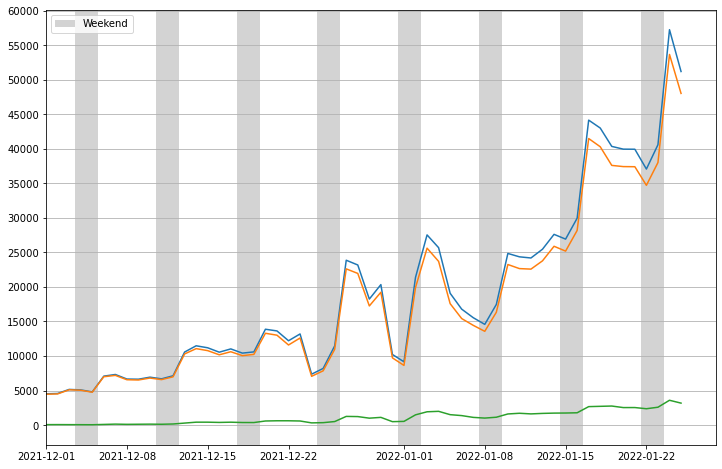

In [123]:


fig,ax1 = plt.subplots(figsize=(12,8))
curCases,curDates = getCases()
ax1.plot(curDates,curCases)
# curCases,curDates = getCases(includeReinfections=False)
# ax1.plot(curDates,curCases)
curCases,curDates,reInfections = getCases(includeReinfections=False,returnReinfections=True)
ax1.plot(curDates,curCases)
ax1.plot(curDates,reInfections)
# ax1.plot(rnTime(curDates,7),rnMean(curCases,7))
# curCases,curDates = getCases(type='7daymean')
# ax1.plot(curDates,curCases,':')
# curCases,curDates = getCases(type='WeeklySum')
# ax1.step(curDates,curCases/7,where='post')


ax1.set_yticks(np.arange(0,64000,5000))
# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 20
for k in range(-numWeeks,numWeeks):
     curSunday = firstSunday + np.timedelta64(7*k,'D')
     ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')
ax1.grid(axis='y')
ax1.legend(loc='upper left')


ax1.set_xlim(left=np.datetime64('2021-12-01'))
ax1.set_xlim(right=np.datetime64('today'))

In [177]:

def getLatest(type='cases'):

    dfToReturn = pd.DataFrame()

    if (type == 'cases'):
        # Re-infection data is not available before 2021-01-01, so the old data file is used first:
        latestsubdir = list(os.walk(path_data))[0][1][-1]
        latestdir = path_data + latestsubdir
        dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
        dfCase = dfCase.iloc[:-2]
        dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))
        dfCase['Date'] =  pd.to_datetime(dfCase.Date,format='%Y-%m-%d')
        # Remove dates outside range
        dfCase = dfCase[dfCase.Date < np.datetime64('2021-01-01')]

        dfToReturn1 = pd.DataFrame()
        dfToReturn1['Date'] = dfCase.Date
        dfToReturn1['NewCases'] = dfCase.NewPositive 
        dfToReturn1['Reinfections'] = np.nan*dfCase.NewPositive
        dfToReturn1['Total'] = dfCase.NewPositive
        
        # Correct loading, using the regional dashboard files which include both new cases and reinfections
        latestsubdir = list(os.walk(path_dash))[0][1][-1]
        latestdir = path_dash + latestsubdir

        df = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
        df['Prøvedato'] = pd.to_datetime(df['Prøvedato'])
        # groupdf = df.groupby(['Prøvedato').sum()
        df_reinf = df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
        df_inf = df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()

        curDates = df_inf.index.values 

        newCases = df_inf.infected.values
        reInfCases = df_reinf.infected.values

        dfToReturn2 = pd.DataFrame()
        dfToReturn2['Date'] = curDates
        dfToReturn2['NewCases'] = newCases 
        dfToReturn2['Reinfections'] = reInfCases
        dfToReturn2['Total'] = newCases+reInfCases

    
        # Prepend earlier data
        dfToReturn = pd.concat([dfToReturn1,dfToReturn2],ignore_index=True)

    # ---------------------------------------------------------------------------------------
    # ------------------------------------- ADMISSIONS --------------------------------------
    # ---------------------------------------------------------------------------------------
    # Admissions are based on date of registration
    elif (type == 'admissions'):
        # Load data from "noegletal"
        # Until 2021-12-20, all dates were included in one file. Since then, additional data was added, and the file only contains the most recent numbers

        latestsubdirs_dash = list(os.walk(path_dash))[0][1]
        # latestsubdirs_dash == 'SSI_dashboard_2021-12-17'
        lastFullFileIndex = np.where([x == 'SSI_dashboard_2021-12-17' for x in latestsubdirs_dash])[0][0]
        latestdir_dash = path_dash + latestsubdirs_dash[lastFullFileIndex]

        dfKey = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')

        dfKeysArray = []
        for k in range(lastFullFileIndex+1,len(latestsubdirs_dash)):
            
            latestdir_dash = path_dash + latestsubdirs_dash[k]
            curdf = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')
            dfKeysArray.append(curdf)
            

        dfKey['IndberetningDato'] = pd.to_datetime(dfKey['IndberetningDato'])

        # Make arrays to plot
        keyDates = dfKey.IndberetningDato
        keyDatesShift = keyDates + np.timedelta64(365,'D')
        keyCase = dfKey['Antal nye bekræftede tilfælde']
        keyNewAdm = dfKey['Antal nye indlæggelser']
        keyAdm = dfKey['Antal indlagte i dag med COVID']
        keyAdmInt = dfKey['Antal indlagt i dag på intensiv']
        keyAdmResp = dfKey['Antal indlagt i dag og i respirator']
        keyDeath = dfKey['Antal nye døde']

        ## Add the new data

        # 2021-12-20 still used old names
        dateToAdd = np.datetime64(pd.to_datetime(dfKeysArray[0].IndberetningDato.values[0]))
        keyDates = np.append(keyDates,dateToAdd)
        keyCase = np.append(keyCase,dfKeysArray[0]['Antal nye bekræftede tilfælde'][0])
        keyNewAdm = np.append(keyNewAdm,dfKeysArray[0]['Antal nye indlæggelser'][0])
        keyAdm = np.append(keyAdm,dfKeysArray[0]['Antal indlagte i dag med COVID'][0])
        keyAdmInt = np.append(keyAdmInt,dfKeysArray[0]['Antal indlagt i dag på intensiv'][0])
        keyAdmResp = np.append(keyAdmResp,dfKeysArray[0]['Antal indlagt i dag og i respirator'][0])
        keyDeath = np.append(keyDeath,dfKeysArray[0]['Antal nye døde'][0])

        # Make an array for missing reinfection data
        keyCaseReInf = keyCase * np.nan 

        # After which the new names are used
        for k in range(1,len(dfKeysArray)):
            thisDate = dfKeysArray[k].Dato[0]
            thisCase = dfKeysArray[k]['Bekræftede tilfælde siden sidste opdatering'][0]
            thisNewAdm = dfKeysArray[k]['Nyindlæggelser siden sidste opdatering'][0]
            thisDeath = dfKeysArray[k]['Dødsfald siden sidste opdatering'][0]
            thisAdm = dfKeysArray[k]['Indlæggelser i dag'][0]
            thisAdmInt = dfKeysArray[k]['Indlæggelser i dag (intensiv)'][0]
            thisAdmResp = dfKeysArray[k]['Indlæggelser i dag (respirator)'][0]
            
            
            thisCaseReInf = dfKeysArray[k]['Reinfektioner siden sidste opdatering'][0]

            keyDates = np.append(keyDates,np.datetime64(thisDate))
            keyCase = np.append(keyCase,thisCase)
            keyNewAdm = np.append(keyNewAdm,thisNewAdm)
            keyAdm = np.append(keyAdm,thisAdm)
            keyAdmInt = np.append(keyAdmInt,thisAdmInt)
            keyAdmResp = np.append(keyAdmResp,thisAdmResp)
            keyDeath = np.append(keyDeath,thisDeath)

            keyCaseReInf = np.append(keyCaseReInf,thisCaseReInf)


        keyDates = keyDates.astype('datetime64[D]')

        # Collect everything in a single dataframe
        dfToReturn = pd.DataFrame()
        dfToReturn['Date'] = keyDates
        dfToReturn['Cases_New'] = keyCase
        dfToReturn['Cases_Reinfection'] = keyCaseReInf
        dfToReturn['New_Admissions'] = keyNewAdm
        dfToReturn['Hospitalizations'] = keyAdm
        dfToReturn['ICU'] = keyAdmInt
        dfToReturn['Respirator'] = keyAdmResp
        dfToReturn['Deaths'] = keyDeath
    else:
        print('Error, invalid type of data asked for in getLatest-function')

    return dfToReturn



In [179]:
getLatest('cases') 
getLatest('admissions')



# dfToReturn = pd.DataFrame()

# latestsubdir = list(os.walk(path_data))[0][1][-1]
# latestdir = path_data + latestsubdir
# dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
# dfCase = dfCase.iloc[:-2]
# dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))
# dfCase['Date'] =  pd.to_datetime(dfCase.Date,format='%Y-%m-%d')
# # Remove dates outside range
# dfCase = dfCase[dfCase.Date < np.datetime64('2021-01-01')]

# dfCase

# dfToReturn['Date'] = dfCase.Date
# dfToReturn['NewCases'] = dfCase.NewPositive 
# dfToReturn['Reinfections'] = np.nan*dfCase.NewPositive
# dfToReturn['Total'] = dfCase.NewPositive

# dfToReturn


,Date,Cases_New,Cases_Reinfection,New_Admissions,Hospitalizations,ICU,Respirator,Deaths
0,2020-04-02,0,NaN,0,527,146,124,0
1,2020-04-03,0,NaN,50,511,139,121,0
2,2020-04-04,0,NaN,57,498,137,115,0
3,2020-04-05,0,NaN,39,490,138,111,0
4,2020-04-06,0,NaN,38,488,133,110,0
...,...,...,...,...,...,...,...,...
649,2022-01-21,43671,3160.0,244,813,44,29,21
650,2022-01-24,37847,2501.0,242,894,43,29,13
651,2022-01-25,43734,2856.0,318,918,44,28,14
652,2022-01-26,43719,3028.0,298,938,40,25,21


In [175]:
# # Correct loading, using the regional dashboard files which include both new cases and reinfections
# latestsubdir = list(os.walk(path_dash))[0][1][-1]
# latestdir = path_dash + latestsubdir

# df = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
# df['Prøvedato'] = pd.to_datetime(df['Prøvedato'])
# # groupdf = df.groupby(['Prøvedato').sum()
# df_reinf = df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
# df_inf = df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()

# curDates = df_inf.index.values 

# newCases = df_inf.infected.values
# reInfCases = df_reinf.infected.values


# dfToReturn2 = pd.DataFrame()
# dfToReturn2['Date'] = curDates
# dfToReturn2['NewCases'] = newCases 
# dfToReturn2['Reinfections'] = reInfCases
# dfToReturn2['Total'] = newCases+reInfCases

# qwer = pd.concat([dfToReturn,dfToReturn2],ignore_index=True)

# # qwer.iloc[330:350]

In [140]:
# Load data from "noegletal"
# Until 2021-12-20, all dates were included in one file. Since then, additional data was added, and the file only contains the most recent numbers

latestsubdirs_dash = list(os.walk(path_dash))[0][1]
# latestsubdirs_dash == 'SSI_dashboard_2021-12-17'
lastFullFileIndex = np.where([x == 'SSI_dashboard_2021-12-17' for x in latestsubdirs_dash])[0][0]
latestdir_dash = path_dash + latestsubdirs_dash[lastFullFileIndex]

dfKey = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')

dfKeysArray = []
for k in range(lastFullFileIndex+1,len(latestsubdirs_dash)):
    
    latestdir_dash = path_dash + latestsubdirs_dash[k]
    curdf = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')
    dfKeysArray.append(curdf)
    

dfKey['IndberetningDato'] = pd.to_datetime(dfKey['IndberetningDato'])

print(dfKey.columns)
dfKey.tail()

# Make arrays to plot
keyDates = dfKey.IndberetningDato
keyDatesShift = keyDates + np.timedelta64(365,'D')
keyCase = dfKey['Antal nye bekræftede tilfælde']
keyNewAdm = dfKey['Antal nye indlæggelser']
keyAdm = dfKey['Antal indlagte i dag med COVID']
keyAdmInt = dfKey['Antal indlagt i dag på intensiv']
keyAdmResp = dfKey['Antal indlagt i dag og i respirator']
keyDeath = dfKey['Antal nye døde']

## Add the new data

# 2021-12-20 still used old names
dateToAdd = np.datetime64(pd.to_datetime(dfKeysArray[0].IndberetningDato.values[0]))
keyDates = np.append(keyDates,dateToAdd)
keyCase = np.append(keyCase,dfKeysArray[0]['Antal nye bekræftede tilfælde'][0])
keyNewAdm = np.append(keyNewAdm,dfKeysArray[0]['Antal nye indlæggelser'][0])
keyAdm = np.append(keyAdm,dfKeysArray[0]['Antal indlagte i dag med COVID'][0])
keyAdmInt = np.append(keyAdmInt,dfKeysArray[0]['Antal indlagt i dag på intensiv'][0])
keyAdmResp = np.append(keyAdmResp,dfKeysArray[0]['Antal indlagt i dag og i respirator'][0])
keyDeath = np.append(keyDeath,dfKeysArray[0]['Antal nye døde'][0])

# Make an array for missing reinfection data
keyCaseReInf = keyCase * np.nan 

# After which the new names are used
for k in range(1,len(dfKeysArray)):
    thisDate = dfKeysArray[k].Dato[0]
    thisCase = dfKeysArray[k]['Bekræftede tilfælde siden sidste opdatering'][0]
    thisNewAdm = dfKeysArray[k]['Nyindlæggelser siden sidste opdatering'][0]
    thisDeath = dfKeysArray[k]['Dødsfald siden sidste opdatering'][0]
    thisAdm = dfKeysArray[k]['Indlæggelser i dag'][0]
    thisAdmInt = dfKeysArray[k]['Indlæggelser i dag (intensiv)'][0]
    thisAdmResp = dfKeysArray[k]['Indlæggelser i dag (respirator)'][0]
    # # print(dfKeysArray[k])
    # print(thisDate)
    # print(thisAdm)
    # print(thisAdmInt)
    
    thisCaseReInf = dfKeysArray[k]['Reinfektioner siden sidste opdatering'][0]

    keyDates = np.append(keyDates,np.datetime64(thisDate))
    keyCase = np.append(keyCase,thisCase)
    keyNewAdm = np.append(keyNewAdm,thisNewAdm)
    keyAdm = np.append(keyAdm,thisAdm)
    keyAdmInt = np.append(keyAdmInt,thisAdmInt)
    keyAdmResp = np.append(keyAdmResp,thisAdmResp)
    keyDeath = np.append(keyDeath,thisDeath)

    keyCaseReInf = np.append(keyCaseReInf,thisCaseReInf)


keyDates = keyDates.astype('datetime64[D]')
keyDatesShift = keyDates + np.timedelta64(365,'D')

# Collect everything in a single dataframe
dfKeyFull = pd.DataFrame()
dfKeyFull['Date'] = keyDates
dfKeyFull['Cases_New'] = keyCase
dfKeyFull['Cases_Reinfection'] = keyCaseReInf
dfKeyFull['New_Admissions'] = keyNewAdm
dfKeyFull['Hospitalizations'] = keyAdm
dfKeyFull['ICU'] = keyAdmInt
dfKeyFull['Respirator'] = keyAdmResp
dfKeyFull['Deaths'] = keyDeath
dfKeyFull.columns

Index(['IndberetningDato', 'Totalt antal tests', 'Antal testede personer',
       'Antal bekræftede tilfælde', 'Antal døde',
       'Antal nye bekræftede tilfælde', 'Antal nye døde',
       'Antal indlagte i dag med COVID', 'Antal indlagt i dag og i respirator',
       'Antal indlagt i dag på intensiv', 'Antal nye indlæggelser',
       'Ændring i antal indlæggelser', 'Ændring i antal i respirator',
       'Ændring i antal på intensiv', 'Førstegangstestede',
       'Antal prøver siden sidst', 'Daily_Infected_Diff', 'Test_totalPCR',
       'Test_totalAG', 'Daily_Antigen_tests', 'Daily_PCR_tests',
       'Daily_antigentest_diff', 'Daily_pcrtest_diff'],
      dtype='object')


Index(['Date', 'Cases_New', 'Cases_Reinfection', 'New_Admissions',
       'Hospitalizations', 'ICU', 'Respirator', 'Deaths'],
      dtype='object')

In [185]:

def addWeekendsToAx(ax):
    
    # Draw weekends
    firstSunday = np.datetime64('2020-02-02')
    numWeeks = 200
    for k in range(-numWeeks,numWeeks):
        curSunday = firstSunday + np.timedelta64(7*k,'D')
        ax.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')
    # ax.grid(axis='y')

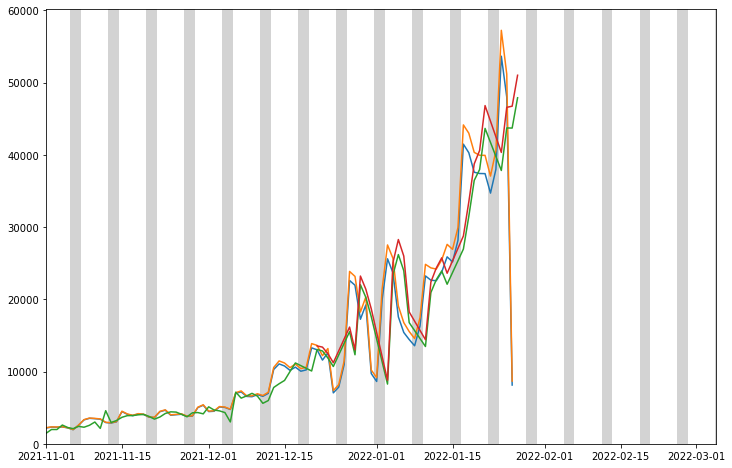

In [186]:


df_test = getLatest()
df_test 
fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(df_test.Date,df_test.NewCases)
ax1.plot(df_test.Date,df_test.Total)

ax1.plot(dfKeyFull.Date,dfKeyFull.Cases_New)
ax1.plot(dfKeyFull.Date,dfKeyFull.Cases_New+dfKeyFull.Cases_Reinfection)

ax1.set_xlim(left=np.datetime64('2021-11'))
ax1.set_ylim(bottom=0)

addWeekendsToAx(ax1)


In [106]:



# latestsubdir = list(os.walk(path_data))[0][1][-1]
# latestdir = path_data + latestsubdir
# dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
# dfCase = dfCase.iloc[:-2]
# dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))

In [107]:
# latestsubdir = list(os.walk(path_dash))[0][1][-1]
# latestdir = path_dash + latestsubdir

# df = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
# df['Prøvedato'] = pd.to_datetime(df['Prøvedato'])
# # groupdf = df.groupby(['Prøvedato').sum()
# df_reinf = df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
# df_inf = df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()
# # df_reinf
# # groupdf = df.groupby(['Prøvedato', 'Type af tilfælde (reinfektion eller bekræftet tilfælde)']).sum()

# # kortdf  = pd.read_csv(latestdir+'/Regionalt_DB/13_regionale_kort.csv',encoding='latin1',delimiter = ';')
# # kortdf

In [108]:

# fig,ax1 = plt.subplots(figsize=(12,8))

# ax1.plot(df_inf.index,df_inf['infected'])
# ax1.plot(df_reinf.index,df_reinf['infected'])
# ax1.plot(df_inf.index,df_inf['infected']+df_reinf['infected'])
# curCases,curDates = getCases()
# ax1.plot(curDates,curCases,'--')
# ax1.set_xlim(left=np.datetime64('2021-12-01'))

# ax1.set_ylim(bottom=0)

In [109]:
# df_inf.tail(20)

In [110]:
# df[df['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '2.Bekræftede tilfælde'].tail(20)

In [93]:

latestsubdir = list(os.walk(path_data))[0][1][-1]
latestdir = path_data + latestsubdir

dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
dfCase = dfCase.iloc[:-2]
dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))
dfCase.tail(10)

,Date,NewPositive,NotPrevPos,PosPct,PrevPos,Tested,Tested_kumulativ
721,2022-01-17,41675,221.528,"18,8",24.217,245.745,56.659.298
722,2022-01-18,40472,212.578,"19,0",23.069,235.647,56.894.945
723,2022-01-19,37789,201.580,"18,7",23.163,224.743,57.119.688
724,2022-01-20,37589,226.731,"16,6",25.175,251.906,57.371.594
725,2022-01-21,37622,204.700,"18,4",22.304,227.004,57.598.598
726,2022-01-22,34812,155.051,"22,5",17.794,172.845,57.771.443
727,2022-01-23,38128,164.124,"23,2",18.737,182.861,57.954.304
728,2022-01-24,53840,232.790,"23,1",26.850,259.640,58.213.944
729,2022-01-25,48221,203.308,"23,7",22.764,226.072,58.440.016
730,2022-01-26,8201,38.896,"21,1",4.917,43.813,58.483.829


In [98]:
latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

df_key = pd.read_csv(latestdir+'/Regionalt_DB/01_noegle_tal.csv',encoding='latin1',delimiter = ';')


,Dato,Region,Køn,Bekræftede tilfælde i alt,Bekræftede tilfælde,Reinfektioner,Døde,Indlæggelser,Testede personer,test_totalAG,...,Indlæggelser i dag (psykiatri),Ændring i antal bekræftede tilfælde i alt,Ændring i antal bekræftede tilfælde,Ændring i antal reinfektioner,Ændring i antal døde,Ændring i antal indlagte,Ændring i antallet af testede personer,Ændring i antallet af PCR prøver,Ændring i antallet af Antigen prøver,Ændring i indlæggelser (psykiatri) siden sidste opdatering
0,2022-01-27,Hovedstaden,F,343942,323639,20303,843,7429,894133,10184106,...,57,7623,6850,773,6,70,351,37264,29393,-4
1,2022-01-27,Hovedstaden,M,322731,305341,17390,982,7104,851913,9316159,...,78,6860,6223,637,2,64,449,29501,26917,0
2,2022-01-27,Midtjylland,F,154415,149410,5005,230,2020,610293,6505923,...,12,6095,5782,313,1,40,500,27904,24679,2
3,2022-01-27,Midtjylland,M,149212,144802,4410,283,2163,597256,6099488,...,17,5647,5409,238,1,23,637,20770,22587,0
4,2022-01-27,Nordjylland,F,62442,60575,1867,122,949,272961,2952019,...,4,2869,2735,134,1,7,194,13417,10589,0
5,2022-01-27,Nordjylland,M,62101,60331,1770,169,1039,272072,2817602,...,10,2714,2593,121,2,10,256,10423,10035,0
6,2022-01-27,Sjælland,F,109637,105625,4012,264,2465,381828,4041761,...,11,3918,3693,225,2,34,408,21424,14635,-1
7,2022-01-27,Sjælland,M,104043,100719,3324,343,2628,372018,3755627,...,17,3723,3526,197,0,24,498,16792,13693,2
8,2022-01-27,Syddanmark,F,134455,130612,3843,182,1856,560088,6005272,...,15,5909,5655,254,2,27,489,31144,21376,1
9,2022-01-27,Syddanmark,M,129751,126252,3499,225,1933,550839,5483514,...,5,5454,5239,215,1,17,601,23379,19654,0


(20000.0, 40000.0)

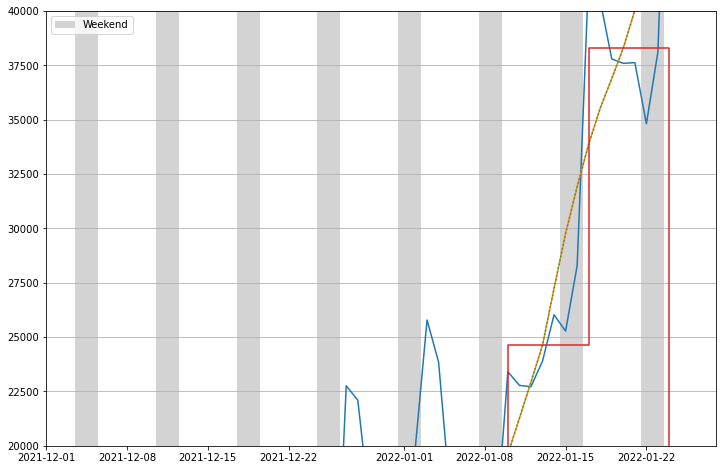

In [70]:


fig,ax1 = plt.subplots(figsize=(12,8))
curCases,curDates = getCases()
ax1.plot(curDates,curCases)
ax1.plot(rnTime(curDates,7),rnMean(curCases,7))
curCases,curDates = getCases(type='7daymean')
ax1.plot(curDates,curCases,':')
curCases,curDates = getCases(type='WeeklySum')
ax1.step(curDates,curCases/7,where='post')

# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 20
for k in range(-numWeeks,numWeeks):
     curSunday = firstSunday + np.timedelta64(7*k,'D')
     ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')
ax1.grid(axis='y')
ax1.legend(loc='upper left')


ax1.set_xlim(left=np.datetime64('2021-12-01'))
ax1.set_xlim(right=np.datetime64('today'))
ax1.set_ylim([20000,40000])

In [60]:

curCasesW,curDatesW = getCases(type='WeeklySum')
curCases,curDates = getCases()
curDates[-7:]
curDates[-2:]
curCases[-2:].sum()/7
curDates[-2-7:-2]
curCases[-2-7:-2].sum()/7

38298.142857142855

In [67]:

print(curDatesW[-3:])
print(curCasesW[-3:]/7)
# curDates[:10]
# curCasesW

['2022-01-10' '2022-01-17' '2022-01-24']
[24625.71428571 38298.14285714 14580.14285714]


In [40]:
latestsubdir = list(os.walk(path_data))[0][1][-1]
latestdir = path_data + latestsubdir

dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
dfCase = dfCase.iloc[:-2]
dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))

dfCase['Date'] =  pd.to_datetime(dfCase.Date,format='%Y-%m-%d')

# # Remove dates outside range
# dfCase = dfCase[(dfCase.Date >= firstDate) & (dfCase.Date <= lastDate)]
dfCase

,Date,NewPositive,NotPrevPos,PosPct,PrevPos,Tested,Tested_kumulativ
0,2020-01-27,0,0,"0,0",0,0,0
1,2020-01-28,0,0,"0,0",0,0,0
2,2020-01-29,0,0,"0,0",0,0,0
3,2020-01-30,0,0,"0,0",0,0,0
4,2020-01-31,0,0,"0,0",0,0,0
...,...,...,...,...,...,...,...
726,2022-01-22,34812,155.051,"22,5",17.794,172.845,57.771.443
727,2022-01-23,38128,164.124,"23,2",18.737,182.861,57.954.304
728,2022-01-24,53840,232.790,"23,1",26.850,259.640,58.213.944
729,2022-01-25,48221,203.308,"23,7",22.764,226.072,58.440.016


In [32]:

# dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
# dfCase = dfCase.iloc[:-2]
# dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))

# dfCase['Date'] =  pd.to_datetime(dfCase.Date,format='%Y-%m-%d')

# # dfCase.Date
# firstDate=np.datetime64('2020-01-27')
# lastDate=np.datetime64('today')
# len(dfCase[(dfCase.Date >= firstDate) & (dfCase.Date <= lastDate)])

In [33]:
# curWeekDay = pd.to_datetime(firstDate).dayofweek
# firstMonday = firstDate - np.timedelta64(curWeekDay,'D')



# curCases = dfCase['NewPositive'].values
# curDates = dfCase['Date'].values

# curOffset = 0
# curMonday = firstMonday

# casesToReturn = []
# datesToReturn = []
# while (curMonday < lastDate):
#     casesToReturn.append(curCases[curOffset:curOffset+7].sum())
#     datesToReturn.append(curMonday)

#     curMonday = curMonday + np.timedelta64(7,'D')
#     curOffset = curOffset + 7
# plt.figure()
# plt.step(datesToReturn,casesToReturn)
# # casesToReturn[-10:]
# # datesToReturn[-10:]
# # curOffset
# # curCases[curOffset:]


In [34]:
# def getCases(type='raw',includeLatest=False,firstDate=np.datetime64('2020-01-27'),lastDate=np.datetime64('today')):
#     latestsubdir = list(os.walk(path_data))[0][1][-1]
#     latestdir = path_data + latestsubdir

#     dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
#     dfCase = dfCase.iloc[:-2]
#     dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))
    
#     dfCase['Date'] =  pd.to_datetime(dfCase.Date,format='%Y-%m-%d')

#     # Remove dates outside range
#     dfCase = dfCase[(dfCase.Date >= firstDate) & (dfCase.Date <= lastDate)]
    
#     # Latest datapoint is not yet fully counted and should often be ignored.
#     if (includeLatest):
#         curCases = dfCase['NewPositive'].values
#         curDates = dfCase['Date'].values
#     else:
#         curCases = dfCase['NewPositive'].values[:-1]
#         curDates = dfCase['Date'].values[:-1]

    
#     if (type == '7daymean'):
#         return rnMean(curCases,7),rnTime(curDates,7)
#     elif (type == '14daymean'):
#         return rnMean(curCases,14),rnTime(curDates,14)
#     elif (type == '21daymean'):
#         return rnMean(curCases,21),rnTime(curDates,21)
#     elif (type == '28daymean'):
#         return rnMean(curCases,28),rnTime(curDates,28)
#     elif (type == 'WeeklySum'):
#         # Summing from monday to sunday.
#         # If firstDate is not a monday, some days are missing in beginning
#         # If lastDate is not a sunday, some days are missing in the end

#         curWeekDay = pd.to_datetime(firstDate).dayofweek
#         firstMonday = firstDate - np.timedelta64(curWeekDay,'D')

#         curOffset = 0
#         curMonday = firstMonday

#         casesToReturn = []
#         datesToReturn = []
#         while (curMonday < lastDate):
#             casesToReturn.append(curCases[curOffset:curOffset+7].sum())
#             datesToReturn.append(curMonday)

#             curMonday = curMonday + np.timedelta64(7,'D')
#             curOffset = curOffset + 7
        
#         return np.array(casesToReturn),np.array(datesToReturn)
#     else:
#         return curCases,curDates

# def plotMean(xVals,yVals,ax=plt.gca(),meanWidth=7, **kwargs):

#     ax.plot(xVals,yVals,'.:',linewidth=0.5,markersize=2, **kwargs)
#     ax.plot(rnTime(xVals,meanWidth),rnMean(yVals,meanWidth),**kwargs)

#     return 
    

# plt.figure()

# curCases,curDates = getCases(lastDate=np.datetime64('2022-01-21'))
# plt.plot(curDates,curCases)
# curCases,curDates = getCases(type='7daymean',lastDate=np.datetime64('2022-01-21'))
# plt.plot(curDates,curCases)
# curCases,curDates = getCases(type='WeeklySum',lastDate=np.datetime64('2022-01-21'))
# plt.step(curDates,curCases/7)



# plt.xlim(left=np.datetime64('2021-10-01'))
# # plotMean(curDates,curCases,ax=plt.gca(),color='k')
# # plt.plot(curDates,curCases,linewidth=3,linewidth=1)